In [1]:
import numpy as np
import matplotlib.pyplot as plt
from SimPEG import utils
from skimage import data, color
from skimage.transform import  rescale, resize, downscale_local_mean
import scipy.ndimage as ndi
import discretize
from sklearn.mixture import GaussianMixture

%matplotlib inline

# Demonstration of the GMM on a grey scale image

In [2]:
# Load greyscale image
dat = data.camera()

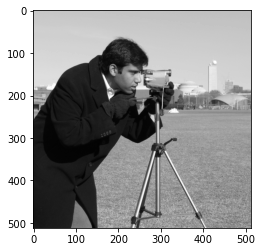

In [3]:
plt.imshow(dat,cmap = 'gray')

In [4]:
n=3
clf = GaussianMixture(n_components=n,  covariance_type='full')
clf.fit(dat.reshape(-1, 1))

GaussianMixture(n_components=3)

Text(0.5, 1.0, 'Segmentation of the image with GMM')

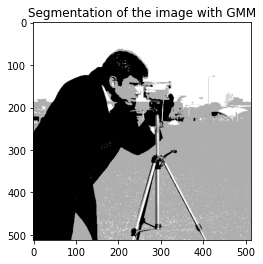

In [5]:
plt.imshow(clf.means_[clf.predict(dat.reshape(-1,1))].reshape(*dat.shape),cmap = 'gray')
plt.gca().set_title('Segmentation of the image with GMM')

# Implementing the GMMRF

**Chosen algorithm: https://doi.org/10.1109/TCSVT.2012.2211176**

In [6]:
from scipy import spatial, linalg

In [7]:
from sklearn.mixture._gaussian_mixture import (
    _compute_precision_cholesky, _compute_log_det_cholesky,
    _estimate_gaussian_covariances_full,
    _estimate_gaussian_covariances_tied,
    _estimate_gaussian_covariances_diag,
    _estimate_gaussian_covariances_spherical,
    _check_means,
    _check_precisions,
    _check_shape,
)
from sklearn.utils import check_array
from scipy.special import logsumexp

In [8]:
class GaussianMixtureMarkovRandomField(GaussianMixture):

    def __init__(
        self, 
        n_components,
        mesh, # the mesh is used to measure the distance between points and find neighboring pixels
        beta = 12.,
        kneighbors=0,
        covariance_type='full',
        init_params='kmeans', max_iter=100,
        means_init=None, n_init=10, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None,
        #**kwargs
    ):
        self.mesh = mesh
        self.kneighbors = kneighbors
        print('Computing KDTree, it may take several minutes.')
        self.tree = spatial.KDTree(self.mesh.gridCC)
        _, self.indexpoint = self.tree.query(self.mesh.gridCC, k=self.kneighbors+1)#, distance_upper_bound=100.)
        self.beta = beta
        
        super(GaussianMixtureMarkovRandomField, self).__init__(
            covariance_type=covariance_type,
            init_params=init_params,
            max_iter=max_iter,
            means_init=means_init,
            n_components=n_components,
            n_init=n_init,
            precisions_init=precisions_init,
            random_state=random_state,
            reg_covar=reg_covar,
            tol=tol,
            verbose=verbose,
            verbose_interval=verbose_interval,
            warm_start=warm_start,
            weights_init=weights_init,
            #**kwargs
        )
        # setKwargs(self, **kwargs)
        
    def computeG(self,z,w):
            logG = (self.beta/(2.*(self.kneighbors+1))) * ((z[self.indexpoint] + w[self.indexpoint]).sum(axis=1))
            
            return logG
        
    def computeB(self, A):
        beta2 = np.zeros(A.shape[1])
        for k in range(A.shape[1]):
            beta2[k] = ((A[:,k][self.indexpoint[:,1:]]- Utils.mkvc(A[:,k],numDims=2))**2.).sum()/self.mesh.nC
        print(beta2)
        return beta2

    def computeA(self, A, z, beta):
        perm = np.random.permutation(self.mesh.nC)
        for i in perm:
            for j in range(self.n_components):
                notjindx = np.where(np.linspace(0,j,j,endpoint=False,dtype='int') != j)
                Aij = A[i,notjindx].sum()
                amj = A[self.indexpoint[i,1:],j].sum()
                coeff2 = Aij - ( amj / self.kneighbors )
                coeff1 = Aij * amj / self.kneighbors
                coeff0 = - 0.5 * z[i,j] * Aij * beta[j] / self.kneighbors
                roots = np.roots(np.r_[1., coeff2, coeff1, coeff0])
                roots = roots[np.isreal(roots)]
                roots = np.real(roots)
                A[i,j] = np.r_[0.,np.real(roots)].max()
                    
        return A
                    
    def _m_step(self, X, log_resp):
        """M step.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        log_resp : array-like, shape (n_samples, n_components)
            Logarithm of the posterior probabilities (or responsibilities) of
            the point of each sample in X.
        """
        n_samples, _ = X.shape
        _ , self.means_, self.covariances_ = (
            self._estimate_gaussian_parameters(X, np.exp(log_resp), self.reg_covar,self.covariance_type)
        )
        #self.weights_ /= n_samples
        self.precisions_cholesky_ = _compute_precision_cholesky(
            self.covariances_, self.covariance_type)
        
        logweights = logsumexp(np.c_[[log_resp, self.computeG(np.exp(log_resp),self.weights_)]],axis=0)
        logweights = logweights - logsumexp(logweights,axis=1,keepdims=True)
        self.weights_= np.exp(logweights)
           
    def _estimate_gaussian_parameters(self, X, resp, reg_covar, covariance_type):
        """Estimate the Gaussian distribution parameters.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input data array.
        resp : array-like, shape (n_samples, n_components)
            The responsibilities for each data sample in X.
        reg_covar : float
            The regularization added to the diagonal of the covariance matrices.
        covariance_type : {'full', 'tied', 'diag', 'spherical'}
            The type of precision matrices.
        Returns
        -------
        nk : array-like, shape (n_components,)
            The numbers of data samples in the current components.
        means : array-like, shape (n_components, n_features)
            The centers of the current components.
        covariances : array-like
            The covariance matrix of the current components.
            The shape depends of the covariance_type.
        """
        nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
        means = np.dot(resp.T, X) / nk[:, np.newaxis]
        covariances = {"full": _estimate_gaussian_covariances_full,
                   "tied": _estimate_gaussian_covariances_tied,
                   "diag": _estimate_gaussian_covariances_diag,
                   "spherical": _estimate_gaussian_covariances_spherical
                   }[covariance_type](resp, X, nk, means, reg_covar)
        return resp, means, covariances
    
    def _check_weights(self,weights, n_components,n_samples):
        """Check the user provided 'weights'.
        Parameters
        ----------
        weights : array-like, shape (n_components,)
            The proportions of components of each mixture.
        n_components : int
            Number of components.
        Returns
        -------
        weights : array, shape (n_components,)
        """
        weights = check_array(weights, dtype=[np.float64, np.float32],
                          ensure_2d=True)
        _check_shape(weights, (n_components,n_samples), 'weights')
        
    def _check_parameters(self, X):
        """Check the Gaussian mixture parameters are well defined."""
        n_samples, n_features = X.shape
        if self.covariance_type not in ['spherical', 'tied', 'diag', 'full']:
            raise ValueError("Invalid value for 'covariance_type': %s "
                             "'covariance_type' should be in "
                             "['spherical', 'tied', 'diag', 'full']"
                             % self.covariance_type)

        if self.weights_init is not None:
            self.weights_init = self._check_weights(self.weights_init,
                                               n_samples,
                                               self.n_components)

        if self.means_init is not None:
            self.means_init = _check_means(self.means_init,
                                           self.n_components, n_features)

        if self.precisions_init is not None:
            self.precisions_init = _check_precisions(self.precisions_init,
                                                     self.covariance_type,
                                                     self.n_components,
                                                     n_features)
            
    def _initialize(self, X, resp):
        """Initialization of the Gaussian mixture parameters.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        resp : array-like, shape (n_samples, n_components)
        """
        n_samples, _ = X.shape

        weights, means, covariances = self._estimate_gaussian_parameters(
            X, resp, self.reg_covar, self.covariance_type)
        weights /= n_samples

        self.weights_ = (weights*np.ones((n_samples,self.n_components)) if self.weights_init is None
                         else self.weights_init)
        self.means_ = means if self.means_init is None else self.means_init

        if self.precisions_init is None:
            self.covariances_ = covariances
            self.precisions_cholesky_ = _compute_precision_cholesky(
                covariances, self.covariance_type)
        elif self.covariance_type == 'full':
            self.precisions_cholesky_ = np.array(
                [linalg.cholesky(prec_init, lower=True)
                 for prec_init in self.precisions_init])
        elif self.covariance_type == 'tied':
            self.precisions_cholesky_ = linalg.cholesky(self.precisions_init,
                                                        lower=True)
        else:
            self.precisions_cholesky_ = self.precisions_init


In [9]:
# define mesh for the image
mesh = discretize.TensorMesh([[( 1.,dat.shape[0])],[( 1.,dat.shape[0])]])

In [10]:
clfmrf = GaussianMixtureMarkovRandomField(
    n_components=n, 
    mesh=mesh,
    kneighbors=24,
    covariance_type='full',
)
clfmrf.fit(dat.reshape(-1,1))

Computing KDTree, it may take several minutes.


GaussianMixtureMarkovRandomField(kneighbors=24,
                                 mesh=
  TensorMesh: 262,144 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    512          0.00        512.00      1.00      1.00    1.00
   y    512          0.00        512.00      1.00      1.00    1.00

,
                                 n_components=3)

Text(0.5, 1.0, 'Segmentation of the image\nwith 3-units GMMRF (smoothest)')

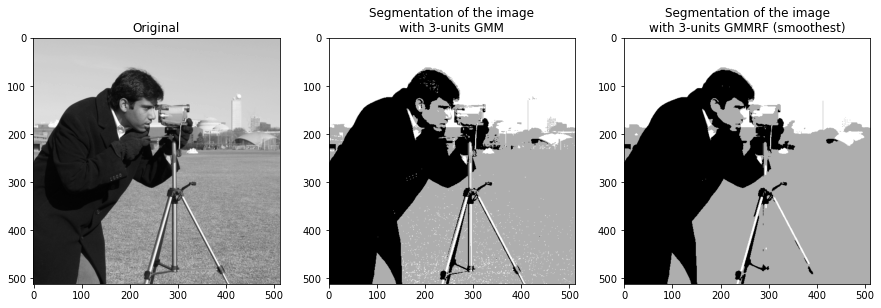

In [11]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

# original
ax[0].imshow(dat,cmap = 'gray')
ax[0].set_title('Original')

#GMM Segmentation
ax[1].imshow(clf.means_[clf.predict(dat.reshape(-1,1))].reshape(*dat.shape),cmap = 'gray')
ax[1].set_title('Segmentation of the image\nwith {}-units GMM'.format(n))

#GMMRF
ax[2].imshow(clfmrf.means_[clfmrf.predict(dat.reshape(-1,1))].reshape(*dat.shape),cmap = 'gray')
ax[2].set_title('Segmentation of the image\nwith {}-units GMMRF (smoothest)'.format(n))

# Test GMMRF on a full RGB picture (multi-features segmentation)

In [12]:
# downscale by 4
ast = rescale(data.astronaut(), 1.0 / 4.0, anti_aliasing=True,multichannel=True,mode='reflect')

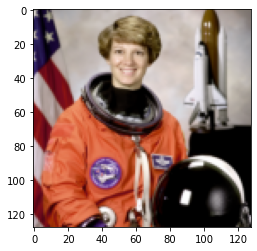

In [13]:
plt.imshow(ast)

In [14]:
mesh = discretize.TensorMesh([[( 1.,ast.shape[0])],[( 1.,ast.shape[0])]])

In [15]:
n=16
clf = GaussianMixture(
    n_components=n
)
clf.fit(ast.reshape(-1, 3))

GaussianMixture(n_components=16)

In [16]:
clfmrf = GaussianMixtureMarkovRandomField(
    n_components=n, 
    mesh=mesh,
    kneighbors=24,
)
clfmrf.fit(ast.reshape(-1,3))

Computing KDTree, it may take several minutes.


GaussianMixtureMarkovRandomField(kneighbors=24,
                                 mesh=
  TensorMesh: 16,384 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    128          0.00        128.00      1.00      1.00    1.00
   y    128          0.00        128.00      1.00      1.00    1.00

,
                                 n_components=16)

Text(0.5, 1.0, 'Segmentation of the image\nwith 16-units GMMRF (smoothest)')

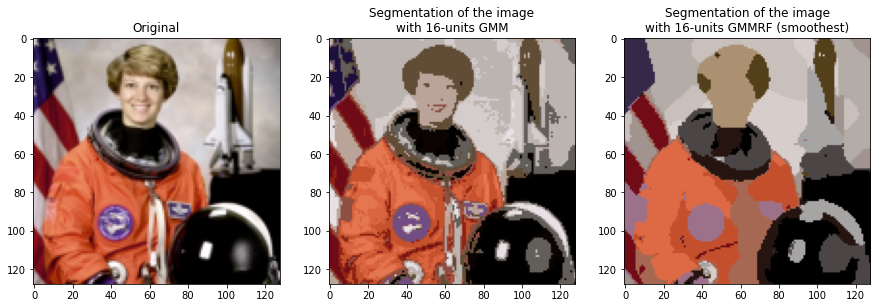

In [17]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

# original
ax[0].imshow(ast)
ax[0].set_title('Original')

#GMM Segmentation
ax[1].imshow(clf.means_[clf.predict(ast.reshape(-1,3))].reshape(*ast.shape))
ax[1].set_title('Segmentation of the image\nwith {}-units GMM'.format(n))

#GMMRF
ax[2].imshow(clfmrf.means_[clfmrf.predict(ast.reshape(-1,3))].reshape(*ast.shape))
ax[2].set_title('Segmentation of the image\nwith {}-units GMMRF (smoothest)'.format(n))